### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller unit root test for stationarity (p-value <0.05 -> TS is stationary)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

### Base

#### Read data

https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/overview

In [154]:
data = pd.read_csv('train_1.csv')

In [155]:
index = 8570
name = data.Page.iloc[index]
time_series = data[data.columns[1:]].iloc[index].to_numpy(dtype=np.float32)[:400]

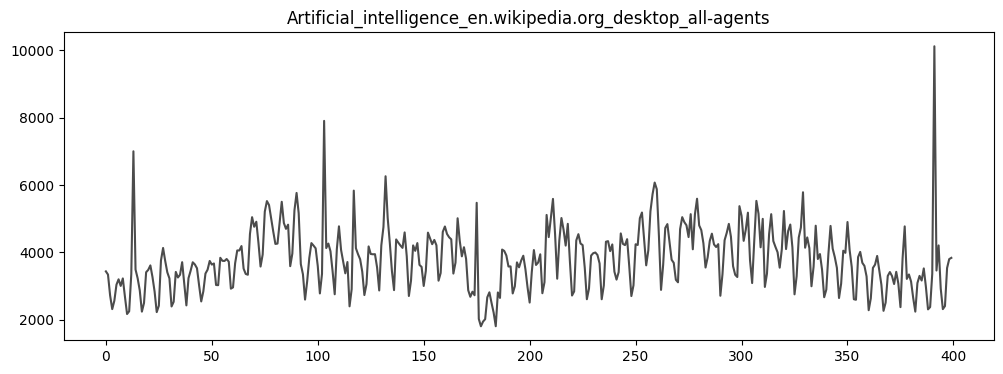

In [156]:
plt.figure(figsize=(12,4))
plt.plot(time_series, color='k', alpha=.7)
plt.title(name)
plt.show()

#### Test for stationarity

In [157]:
def adf_test(timeseries):
    # Augmented Dickey-Fuller
    dftest = adfuller(timeseries, autolag="AIC")
    returns = ['test statistic', 'p-value', 'number of lags used',
               'number of observations used', 'critical values for the test statistic at x%']
    for i, r in enumerate(returns):
      print(f'{r}: {dftest[i]}')
    return dftest

In [158]:
_ = adf_test(time_series) # ADF тест

test statistic: -2.668840432361647
p-value: 0.07958717241553026
number of lags used: 15
number of observations used: 384
critical values for the test statistic at x%: {'1%': -3.4474946672686824, '5%': -2.8690962436986855, '10%': -2.570795299750434}


#### Test for stationarity for deltas

We cannot say for sure about stationarity based on the test

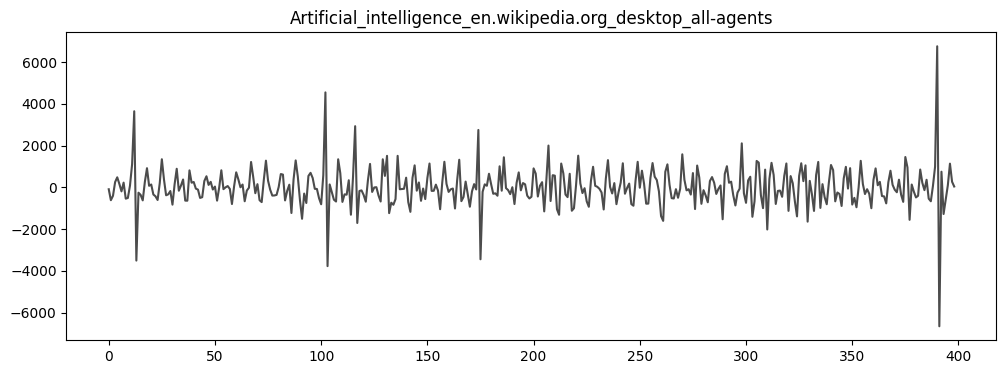

In [159]:
delta_time_series = time_series[1:]-time_series[:-1] # смотрим на первые разности
plt.figure(figsize=(12,4))
plt.plot(delta_time_series, color='k', alpha=.7)
plt.title(name)
plt.show()

In [160]:
_ = adf_test(delta_time_series)

test statistic: -7.37946581094198
p-value: 8.548075039504624e-11
number of lags used: 14
number of observations used: 384
critical values for the test statistic at x%: {'1%': -3.4474946672686824, '5%': -2.8690962436986855, '10%': -2.570795299750434}


Reject the hypothesis of non-stationarity

#### Choosing parameters

Autocorrelation function for choosing value  of part moovingAvarage

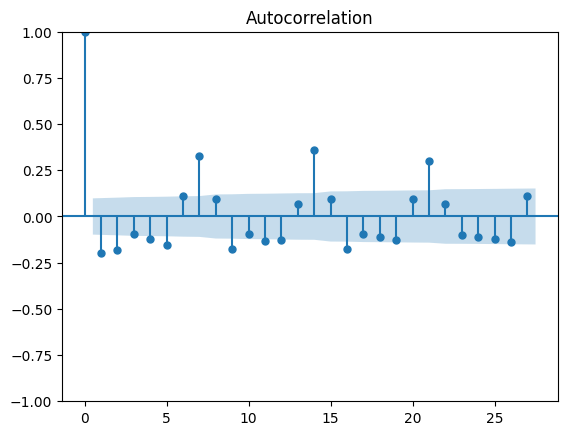

In [217]:
plot_lorenz_acf = plot_acf(delta_time_series)

Partial autocorrelation function for choosing value of part autoRegression

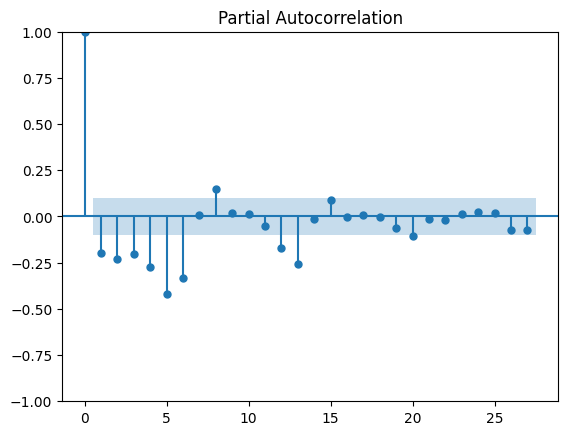

In [216]:
plot_lorenz_pacf=plot_pacf(delta_time_series)

#### Model

Fit

In [218]:
p = 2
d = 2
q = 1
model = ARIMA(time_series, order=(p, d, q))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  400
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -3280.046
Date:                Fri, 22 Dec 2023   AIC                           6568.092
Time:                        01:56:24   BIC                           6584.038
Sample:                             0   HQIC                          6574.408
                                - 400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2412      0.022    -11.067      0.000      -0.284      -0.198
ar.L2         -0.2313      0.036     -6.447      0.000      -0.302      -0.161
ma.L1         -1.0000      0.027    -36.540      0.0

Predict

In [219]:
predictions = res.get_prediction(start=0, end=len(time_series)+10, dynamic=False)
pred_confedance_interval = predictions.conf_int()

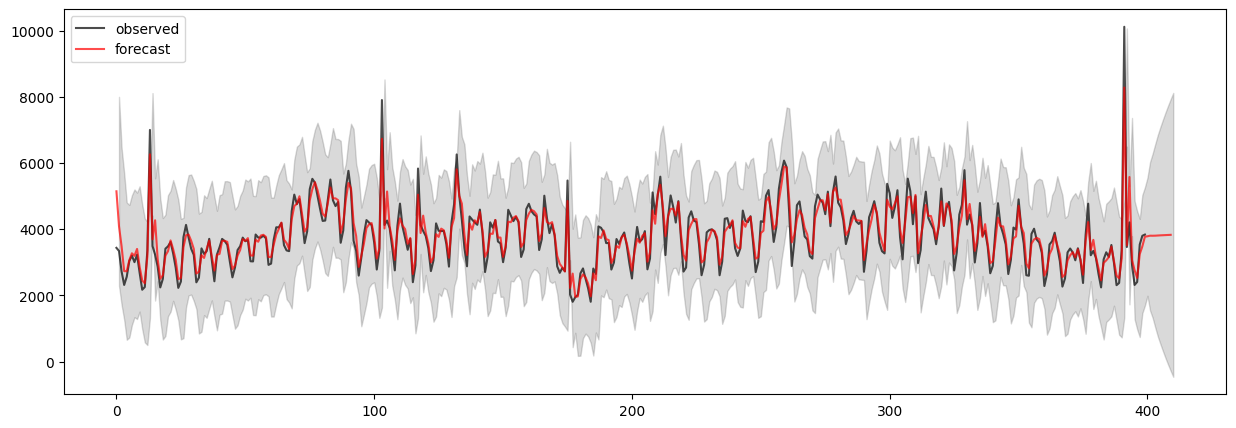

In [220]:
ax = pd.Series(time_series).plot(label='observed', figsize=(15,5), color='k', alpha=.7)

pd.Series(predictions.predicted_mean[1:]).plot(ax=ax, label='forecast', alpha=.7, color='r')
ax.fill_between(np.arange(len(pred_confedance_interval))[1:],
                pred_confedance_interval[1:, 0],
                pred_confedance_interval[1:, 1],
                color='k',
                alpha=.15)
plt.legend()
plt.show()